## Py-ART Animation

This section generates an animation from multiple radar volumes extracted from ROAMES amazon s3 archive. The user is able to select the radar id and the animation start and stop time.

### Original notebook by Zach Sherman:
https://github.com/uq-crg/pyart_animation

### Based on code by Scott Collis:
https://github.com/scollis/radar_in_the_cloud/blob/master/notebooks/Matthew.ipynb 

### Jonathan Helmus:
https://anaconda.org/jjhelmus/scipy2015_openaccessradar_jjh/notebook

### and memory fixes by Robert Jackson:
https://github.com/rcjackson/pyart_practice/blob/master/nexrad_animatedgif.py

Note: AUS radar s3 file times are in UTC. 

In [1]:
#Import additional libraries for animation


#twitter related
import twitter #https://python-twitter.readthedocs.io/en/latest/index.html
import json

#Radar related
import pyart
from mpl_toolkits.basemap import Basemap
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

#For web map service requests
from owslib.wms import WebMapService #https://geopython.github.io/OWSLib/

#For amazon s3 interactions
from boto.s3.connection import S3Connection #Anaconda installable

#Python libraries
import shutil, os, tempfile
from datetime import timedelta, datetime, date
import numpy as np

import gzip
from matplotlib import animation
import pandas as pd
from IPython.display import Image, display


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


This function is for pulling all keys between two dates at a chosen radar site.

In [2]:
def ausrad_site_datespan(start_date=None, start_time=None, 
                         end_date=None, end_time=None, site=None):
    
    """
    Get all volumes from a radar id between two particular datetimes.
    Parameters
    ----------
    start_date : string
        eight number date, for example '20150623'
    start_date_time : string
        six number time, for example '145501'
    end_date : string
        eight number date or 'Now' to retrieve current UTC
    end_date_time : string, optional if end_date = 'Now'
        six number time
    site : string
        two digit radar designation number, for example '02' 
        
    """
    
    def datespan(startDate, endDate, delta=timedelta(days=1)):
        currentDate = startDate
        while currentDate < endDate:
            yield currentDate
            currentDate += delta

    #set user input time format
    fmt = '%Y/%m/%d_%H:%M:%S' 
    
    # Allows for the choice of now for the end date so current UTC is pulled.
    #process time input
    if end_date.upper() == 'NOW':
        e_d_selected = datetime.utcnow()
    else:
        e_d_selected = datetime.strptime(end_date + '_' + end_time, fmt)

    s_d = datetime.strptime(start_date + '_' + start_time, fmt)
    e_d = e_d_selected 
    if s_d > e_d_selected:
            raise ValueError('You provided a start date that comes after the end date.')
    times = []
    for timestamp in datespan((s_d), (e_d), delta=timedelta(days=1)):
        time = timestamp
        times += ["odimh5_archive/" + site + '/' + datetime.strftime(time, '%Y/%m/%d/')]

    #connect to s3 bucket    
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('roames-wxradar-archive')
    
    #Get a list of files from s3
    keys = []
    datetimes = []
    for time in times:
        bucket_list = list(bucket.list(time))   
        for i in range(len(bucket_list)):
            this_str = str(bucket_list[i].key)
            if 'h5' in this_str:
                endme = this_str[-18:-3]
                fmt = '%Y%m%d_%H%M%S' 
                dt = datetime.strptime(endme, fmt)
                datetimes.append(dt)
                keys.append(bucket_list[i])

    # Code belows chooses all keys between the user's dates.
    d = {'keys': keys}
    key_object = pd.DataFrame(data=d, index=pd.to_datetime(datetimes))

    selected_keys = key_object.loc[s_d : e_d, :]
    #radar_datetimes = selected_keys.index.tolist()
    data_keys = selected_keys['keys'].tolist()
    return data_keys

In [3]:
# Conversion of s3 file keys to pyart radar objects.

def radar_keys_to_data(keys):
    #download data from s3
    localfile = tempfile.NamedTemporaryFile()
    keys.get_contents_to_filename(localfile.name)
    #generate radar object
    radar = pyart.aux_io.read_odim_h5(localfile.name, file_field_names=True)
    #correct field names
    radar.fields['DBZH']['standard_name'] = 'Reflectivity'
    radar.fields['DBZH']['units'] = 'dBZ'
    radar.fields['DBZH']['long_name'] = 'Radar Reflectivity Factor'
    radar.altitude['data'] = np.array([r_elv])
    radar.longitude['data'] = np.array([r_lon])
    radar.latitude['data']  = np.array([r_lat])
    return radar

In [4]:
def generate_layers(max_lat,min_lat,max_lon,min_lon):
    """
    Generates a background terrain image and an overlay places/roads image from wms sources
    
    Parameters
    ----------
    min_lat, max_lat, min_lon, max_lon: floats
        bounds for the display
        
    Returns
    -------
    None
    
    """    
    #generate map bounds
    lat_dif   = max_lat-min_lat
    lon_dif   = max_lon-min_lon
    map_x_sz  = int(500*lon_dif)
    map_y_sz  = int(500*lat_dif)

    #create overly map
    wms = WebMapService('http://services.ga.gov.au/site_7/services/Topographic_Base_Map_WM/MapServer/WMSServer?', version='1.1.1')
    img = wms.getmap(layers=['Roads_4','Populated_Places_6'],srs='EPSG:4326',bbox=(min_lon, min_lat, max_lon, max_lat),size=(map_x_sz, map_y_sz),format='image/png',transparent=True)
    out = open('data/overlay.png', 'wb')
    out.write(img.read())
    out.close()  

    #create background map
    wms = WebMapService('http://ows.terrestris.de/osm-gray/service?', version='1.1.1')
    img = wms.getmap(layers=['TOPO-WMS'],srs='EPSG:4326',bbox=(min_lon, min_lat, max_lon, max_lat),size=(map_x_sz, map_y_sz),format='image/png',transparent=True)
    out = open('data/background.png', 'wb')
    out.write(img.read())
    out.close() 

In [5]:
# Creating a gif of all volumes between both dates.

def animate(nframe):
    
    #create basemap
    plt.clf()
    ref_m = Basemap(llcrnrlon=min_lon,
            llcrnrlat=min_lat,
            urcrnrlon=max_lon,
            urcrnrlat=max_lat, 
            projection='tmerc', 
            resolution = 'h',
            epsg = 3857)
    
    #load background image
    im = plt.imread('data/background.png')
    ref_m.imshow(im,zorder = 0,origin='upper')
    #plot radar data
    radar = radar_keys_to_data(my_data_keys[nframe])
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map(field, sweep=sweep, resolution=bm_res,
                         vmin=vmin, vmax=vmax, mask_outside=False,
                         cmap=cmap,lat_lines=lal, lon_lines=lol,
                         basemap = ref_m, zorder = 1)
    #overlay mapping data
    im = plt.imread('data/overlay.png')
    ref_m.imshow(im,zorder = 2,origin='upper')
    #overlay country outlines
    display.basemap.drawcounties()

Alright, now we can generate a gif from the s3 radar data archive

In [ ]:
# Plotting and creating an animation using the radar datas.
# Something close to home.
# Use the option of saying 'now' to retrieve current UTC.

#set vars
radar_id     = '66'
field        = 'DBZH'
sweep        = 1
vmin         = 0
vmax         = 65
start_date   = '2008/11/16'
start_time   = '05:00:00'
end_date     = '2008/11/16'
end_time     = '07:00:00'
max_lat      = -27
min_lat      = -28.3
min_lon      = 152.2
max_lon      = 153.65
r_lat        = -27.7178
r_lon        = 153.2400
r_elv        = 174
bm_res       = 'h' #l (low), i (intermediate), h (high), f (full)
cmap         = pyart.graph.cm.NWSRef

#create lat lon lines
lat_grid  = 0.2
lon_grid  = 0.2
lal       = np.arange(min_lat, max_lat, lat_grid)
lol       = np.arange(min_lon, max_lon, lon_grid)

# build s3 file keys
my_data_keys = ausrad_site_datespan(start_date=start_date,start_time=start_time,
                                         end_date=end_date,end_time=end_time,
                                         site=radar_id)
#confirm keys
print(my_data_keys)

#generate background and overlay images
generate_layers(min_lat = min_lat,max_lat = max_lat,
                min_lon = min_lon, max_lon = max_lon)

#generate images for animation
fig        = plt.figure(figsize=(10, 8))
anim_radar = animation.FuncAnimation(fig, animate, frames=len(my_data_keys))

#save animation
anim_radar.save('data/animation.gif', writer='ImageMagick', fps=2)
plt.close()

[<Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_050034.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_050633.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_051233.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_051833.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_052433.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_053033.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_053633.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_054234.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_054833.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_055434.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_060035.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_060633.h5>, <Key: roames-wx

/home/meso/anaconda2/lib/python2.7/site-packages/matplotlib/animation.py:782: UserWarning: MovieWriter ImageMagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


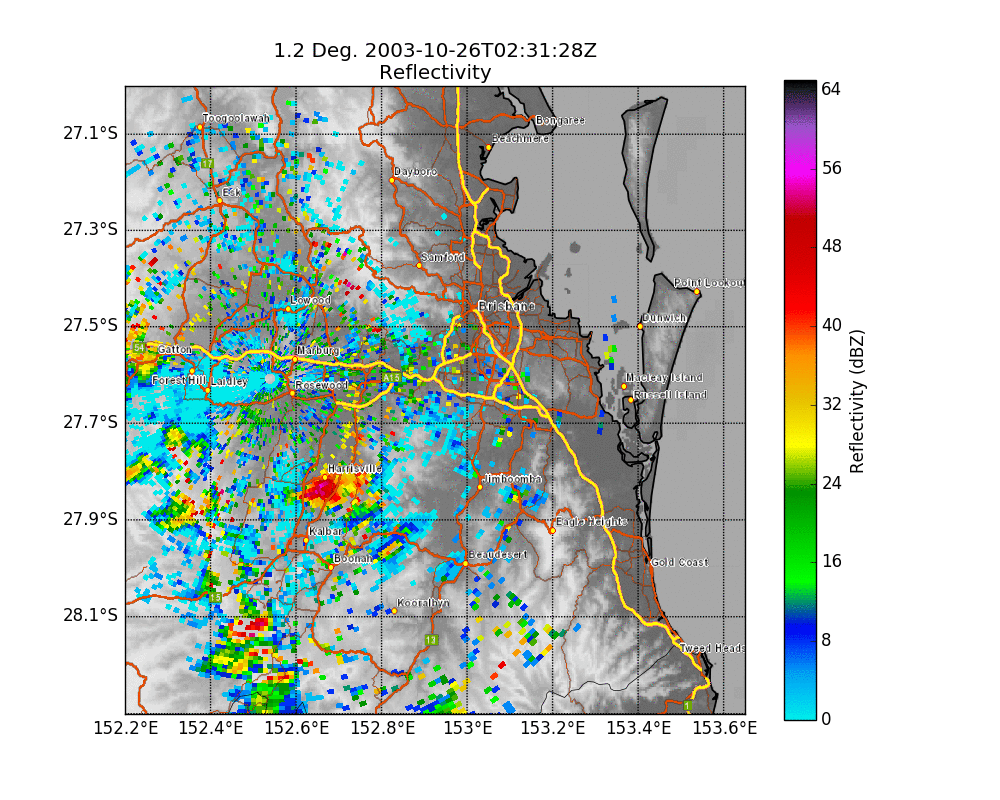

In [11]:
# Open gif in notebook
with open('data/animation.gif','rb') as f:
    display(Image(f.read()), format='png')

In [14]:
np.array([122,114.233,1])

array([ 122.   ,  114.233,    1.   ])